In [ ]:
!pip install tensorflow==2.8.0
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: go

In [ ]:
tf.config.list_physical_devices("GPU")

[]

In [ ]:
!nvidia-smi

Mon Oct 21 13:00:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load a dataset.

In [ ]:
datasets, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train", "test[:50%]" , "test[50%:]"],
    as_supervised=True,
    with_info=True
)
info
len(datasets)
dataset_train_original = datasets[0]
dataset_validate_original = datasets[1]
dataset_test_original = datasets[2]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6HEVTY_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6HEVTY_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6HEVTY_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print("Train size:   ", len(dataset_train_original))
print("Validate size:", len(dataset_validate_original))
print("Test size:    ", len(dataset_test_original))

Train size:    25000
Validate size: 12500
Test size:     12500


## Look at your beeping data.

In [ ]:
for x, y in dataset_train_original.shuffle(25_000).take(8):
    print("x", x.numpy().decode("utf-8"))
    print("y", y.numpy())

x This has got to be the worst horror movie I have ever seen. I remember watching it years ago when it initially came out on video and for some strange reason I thought I enjoyed it. So, like an idiot, I ran out to purchase the DVD once it was released...what a tragic mistake! I won't even bother to go into the plot because it is so transparent that you can see right through it anyhow. I am a fan of Herschell Gordon Lewis so I am accustomed to cheesy gore effects and bad acting but these people take this to a whole different level. It is almost as if they are intentionally trying to make the worst movie humanly possible...if that was their goal, they suceeded. If they intended to make a film that was supposed to scare you or make you believe in any way, shape, or form that it is real then they failed...MISERABLY! Avoid this movie...read the plot synopsis and you've seen it!
y 0
x ***SPOILERS*** ***SPOILERS*** After two so-so outings ("Magnum Force" and "The Enforcer"), Dirty Harry seem

In [ ]:
type(dataset_train_original.take(8))

tensorflow.python.data.ops.dataset_ops.TakeDataset

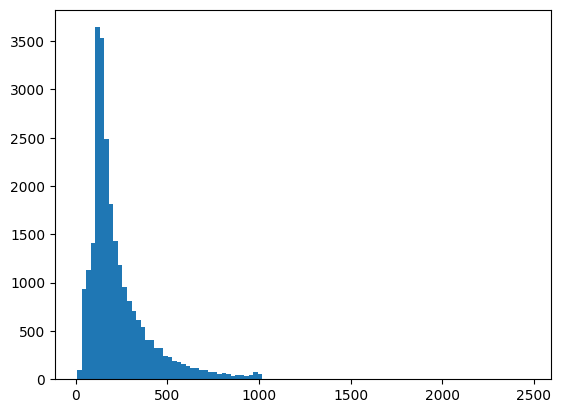

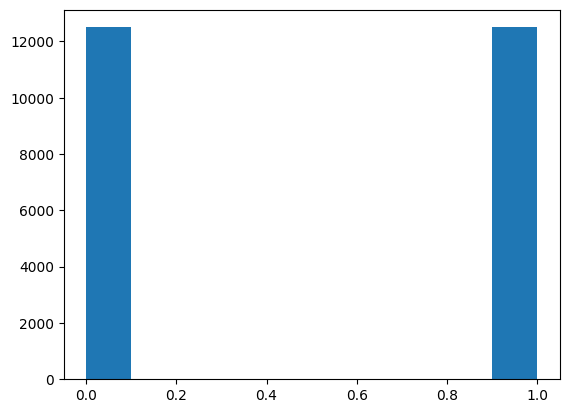

In [ ]:
lengths = []
labels = []
for x, y in dataset_train_original:
    lengths += [len(x.numpy().split())]
    labels += [y.numpy()]

plt.hist(lengths, bins=100)
plt.show()
plt.close()

plt.hist(labels)
plt.show()
plt.close()

## Bag of Words Encoding (Multi-Hot)

In [ ]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="multi_hot"
)
encoder.adapt(dataset_train_original.map(lambda text, _: text).batch(2048))

In [ ]:
vocabulary = encoder.get_vocabulary()
print(vocabulary)

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she', 'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really', 'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because', 'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most', 'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could', 'way', 'them', 'any', 'too', 'after', 'characters', 'think', 'watch', 'two', 'many', 'being', 'seen', 'character', 'never', 'little', 'acting', 'where', 'plot', 'best', 'love', 'did', 'know', 'life', 'show', 'does', 'ever', 'your', 'still', 'better', 'over', 'off', 'these', 'end', '

In [ ]:
text = "You take a mortal man. And put him in control. Watch him become a God. Watch peoples' head aroll."
text_encoded = encoder(text)
print(list(text_encoded.numpy()))

[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Prepare datasets

In [ ]:
dataset_train = dataset_train_original.cache().shuffle(25_000).batch(128)

dataset_validate = dataset_validate_original.cache().batch(128)

dataset_test = dataset_test_original.cache().batch(128)

In [ ]:
for x, y in dataset_train.take(1):
    print(len(x[0].numpy())) # (128)

748


## Train the model.

In [ ]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.build(input_shape=(None,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(tf.constant(["Exit light. Enter night. Take my hand. RUFF to never never land."]))

array([[0.5013528]], dtype=float32)

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.evaluate(dataset_test))

98/98 [==============================] - 2s 16ms/step - loss: 0.6976 - accuracy: 0.4951
[0.6975986957550049, 0.49511998891830444]


In [ ]:
history = model.fit(
    dataset_train,
    epochs=4,
    validation_data=dataset_validate
)

Epoch 1/4
196/196 [==============================] - 6s 28ms/step - loss: 0.3361 - accuracy: 0.8618 - val_loss: 0.2889 - val_accuracy: 0.8815
Epoch 2/4
196/196 [==============================] - 4s 22ms/step - loss: 0.1865 - accuracy: 0.9306 - val_loss: 0.3138 - val_accuracy: 0.8737
Epoch 3/4
196/196 [==============================] - 4s 20ms/step - loss: 0.1400 - accuracy: 0.9484 - val_loss: 0.3716 - val_accuracy: 0.8650
Epoch 4/4
196/196 [==============================] - 5s 27ms/step - loss: 0.1057 - accuracy: 0.9623 - val_loss: 0.3973 - val_accuracy: 0.8640


In [ ]:
history.history

{'loss': [0.33612534403800964,
  0.18645642697811127,
  0.1400492638349533,
  0.10573651641607285],
 'accuracy': [0.861840009689331,
  0.9305999875068665,
  0.9484000205993652,
  0.9622799754142761],
 'val_loss': [0.28894564509391785,
  0.3137964606285095,
  0.37160563468933105,
  0.39734238386154175],
 'val_accuracy': [0.8815199732780457,
  0.8736799955368042,
  0.8649600148200989,
  0.8640000224113464]}

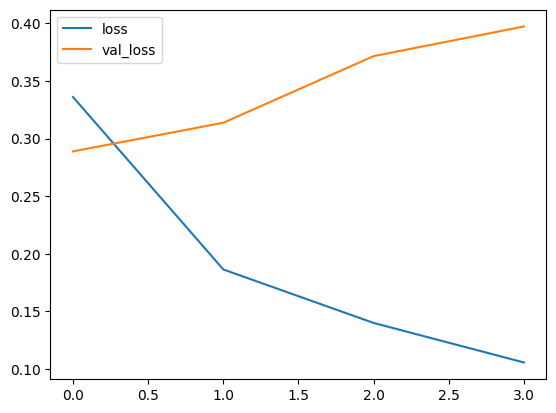

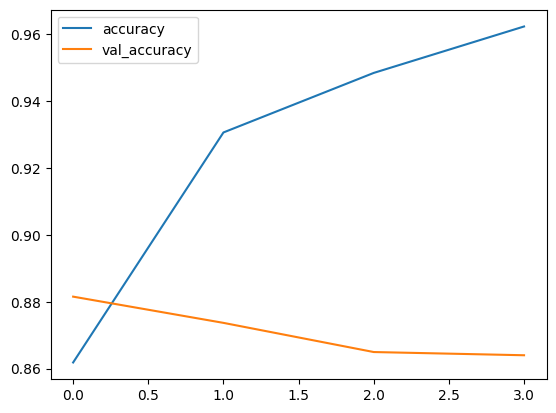

In [ ]:
def render_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()

render_history(history)

## Word Embeddings

In [ ]:
vocabulary_size = 10_000
sequence_length = 128

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size, # Not new.
    output_sequence_length=sequence_length, # New!
    standardize="lower_and_strip_punctuation", # Not new.
    split="whitespace", # Not new.
    output_mode="int" # New!
)

encoder.adapt(dataset_train_original.map(lambda text, _: text).batch(2048))

In [ ]:
vocabulary = encoder.get_vocabulary()
print(vocabulary) # First one is padding token.

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she', 'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really', 'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because', 'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most', 'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could', 'way', 'them', 'any', 'too', 'after', 'characters', 'think', 'watch', 'two', 'many', 'being', 'seen', 'character', 'never', 'little', 'acting', 'where', 'plot', 'best', 'love', 'did', 'know', 'life', 'show', 'does', 'ever', 'your', 'still', 'better', 'over', 'off', 'these', 'end

In [ ]:
text = "One morning in June some twenty years ago I was born a rich man's son."
text_encoded = encoder(text)
print(text_encoded) # Word indices.

tf.Tensor(
[  29 1939    8 4685   47 2115  148  598   10   14 1492    4 1004 1433
  501    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(128,), dtype=int64)


In [ ]:
vocabulary[4685]

'june'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 128, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 324,097
Trainable params: 324,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
196/196 [==============================] - 4s 16ms/step - loss: 0.6330 - accuracy: 0.6531 - val_loss: 0.

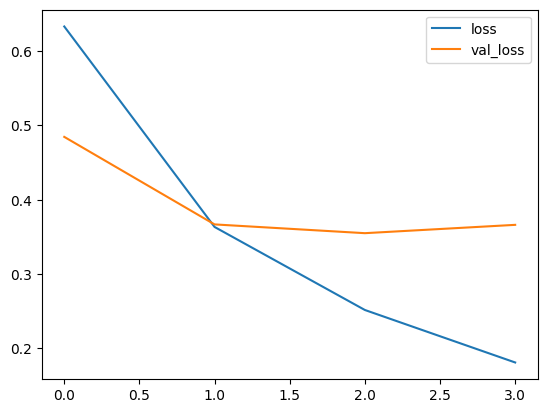

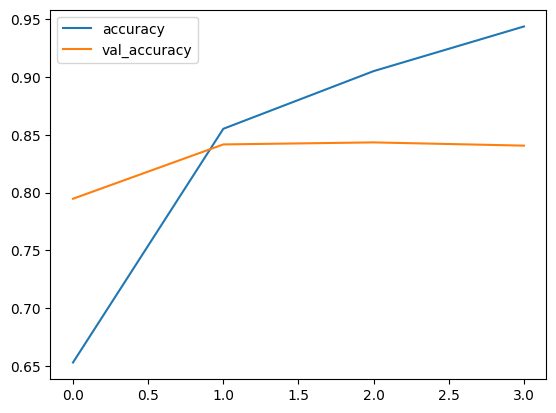

In [ ]:
model = models.Sequential()
model.add(encoder) # Word indices.
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32)) # Word embeddings.
model.add(layers.Flatten()) # "Dimensionality reduction"
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=4,
    validation_data=dataset_validate
)

render_history(history)

# LSTM - Long Short-Term Memory (a Recurrent Neural Network)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 128, 32)           320000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
196/196 [==============================] - 44s 215ms/step - loss: 0.5100 - accuracy: 0.7236 - val_loss: 

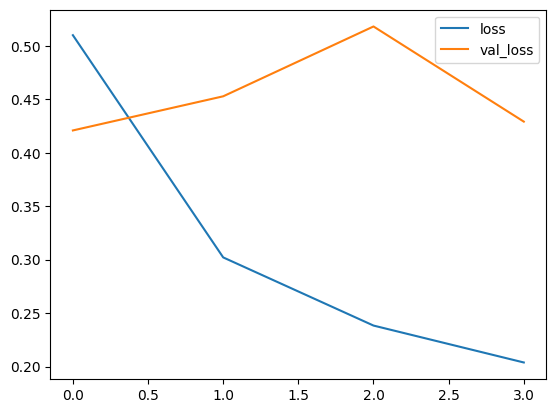

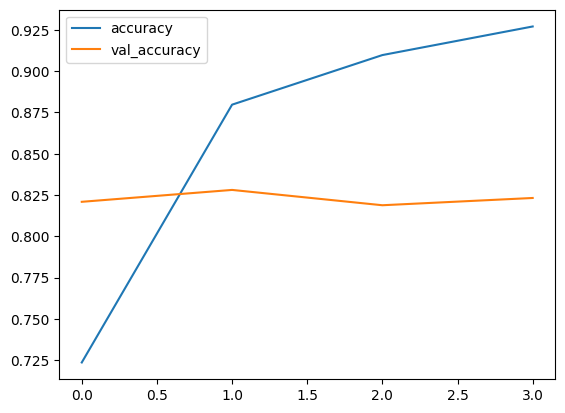

In [ ]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
model.add(layers.LSTM(64))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=4,
    validation_data=dataset_validate
)

render_history(history)